In [1]:
import os
import zarr
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch
import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import UNet_2D, aug
from src.utils import save_images
from src.metric import score, create_cls_pos, create_cls_pos_sikii, create_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
)

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    train=True,
)

from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
train_nshuffle_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in tqdm(train_dataset):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

# normalized_tomogram =
normalized_tomogram.shape[0]

[('TS_5_4', 'denoised'), ('TS_73_6', 'denoised'), ('TS_99_9', 'denoised'), ('TS_6_4', 'denoised'), ('TS_69_2', 'denoised')]
[('TS_86_3', 'denoised'), ('TS_6_6', 'denoised')]


  0%|          | 0/5 [00:00<?, ?it/s]


92

In [3]:
# torchのpadding用の関数
# torch.Size([4, 1, 158, 158]) -> torch.Size([4, 1, 160, 160])


class PadToSize(nn.Module):
    def __init__(self, resolution):
        super().__init__()
        if resolution == "0":
            self.size = 640
        elif resolution == "1":
            self.size = 320
        elif resolution == "2":
            self.size = 160

    def forward(self, x):
        return F.pad(x, (0, 0, self.size - x.shape[-1], self.size - x.shape[-2]))


# test
pad = PadToSize(CFG.resolution)
test_input = torch.randn((4, 1, 158, 158))
print(test_input.shape)
print(pad(test_input).shape)

torch.Size([4, 1, 158, 158])
torch.Size([4, 1, 320, 320])


In [4]:
model = UNet_2D().to("cuda")
model.load_state_dict(torch.load("./pretrained_model.pth"))
# model.eval()

<All keys matched successfully>

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [6]:
class SegmentationLoss(nn.Module):
    def __init__(self, criterion):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        self.criterion = criterion

    def forward(self, output, target):
        # output: (batch, cls, 160, 160)
        # target: (batch, 160, 160)

        # output, (batch, 160, 160, cls) -> (batch, 160, 160, cls)
        # output = output.permute(0, 2, 3, 1)
        # output = output.reshape(-1, output.shape[-1])  # (batch*160*160, cls)

        # target, (batch, 160, 160) -> (batch*160*160)
        # target = target.reshape(-1)

        loss = self.criterion(output, target)
        return loss


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, output, target):
        """
        output: (batch, cls, height, width)
        target: (batch, height, width)
        """
        # Apply softmax to get probabilities
        output = nn.functional.softmax(output, dim=1)

        # One-hot encode the target to match the number of classes in output
        num_classes = output.shape[1]
        target_one_hot = (
            # F.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2).float()
            nn.functional.one_hot(target, num_classes=num_classes)
            .permute(0, 3, 1, 2)
            .float()
        )

        # Flatten for Dice calculation
        output_flat = output.reshape(output.shape[0], output.shape[1], -1)
        target_flat = target_one_hot.reshape(
            target_one_hot.shape[0], target_one_hot.shape[1], -1
        )

        # Compute intersection and union
        intersection = (output_flat * target_flat).sum(dim=2)
        union = output_flat.sum(dim=2) + target_flat.sum(dim=2)

        # Compute Dice score
        dice_score = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Average over classes and batch
        dice_loss = 1.0 - dice_score.mean()

        return dice_loss


# test
dice_loss = DiceLoss()
output = torch.randn((4, 3, 160, 160))
target = torch.randint(0, 3, (4, 160, 160))
print(dice_loss(output, target))

tensor(0.6670)


In [7]:
from transformers import get_cosine_schedule_with_warmup

batch_size = 8

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
# criterion = nn.CrossEntropyLoss(
#     #  weight=torch.tensor([2.0, 32, 32, 32, 32, 32, 32]).to("cuda")
# )
criterion = DiceLoss()
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=CFG.epochs // 10,
    num_training_steps=CFG.epochs
    * len(train_loader)
    * (normalized_tomogram.shape[0] // batch_size),
    # * batch_size,
)
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

Train-Epoch: 0, Loss: 0.7069720042788464: : 46it [00:06,  6.78it/s]                      
Train-nshuffle-Epoch: 0, Loss: 0.7853911621415097: 100%|██████████| 460/460 [00:05<00:00, 77.39it/s] 


EPOCH: 0, TRAIN_SCORE: 0.13967681382632838, TRAIN_SCORE_LIST: [0.12558455926743872, 0.1439385952271281, 0.16728636964632426, 0.12683676004316385, 0.13473778494758695]


Valid-Epoch: 0, Loss: 0.7908281952790592: 100%|██████████| 184/184 [00:02<00:00, 68.37it/s] 


EPOCH: 0, VALID_SCORE: 0.13487622306083868, VALID_SCORE_LIST: [0.13640437713255388, 0.13334806898912346]


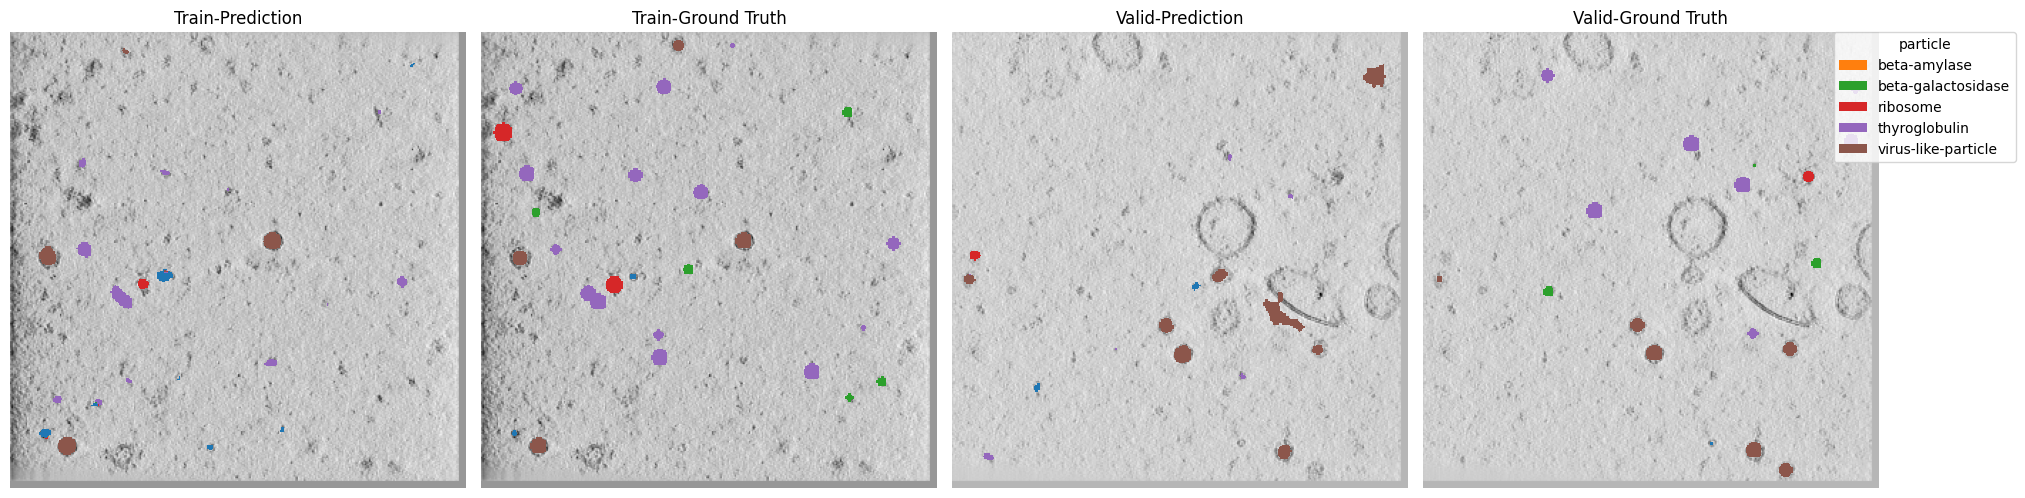

Train-Epoch: 1, Loss: 0.6941543908222861: : 46it [00:06,  7.63it/s]                      
Train-nshuffle-Epoch: 1, Loss: 0.6846514217231585: 100%|██████████| 460/460 [00:05<00:00, 80.70it/s] 


EPOCH: 1, TRAIN_SCORE: 0.25501480327367976, TRAIN_SCORE_LIST: [0.2406004161348228, 0.29111859227680015, 0.2900931086485172, 0.26600014347037326, 0.18726175583788512]


Valid-Epoch: 1, Loss: 0.7189209266849186: 100%|██████████| 184/184 [00:02<00:00, 71.50it/s] 


EPOCH: 1, VALID_SCORE: 0.23513350029569102, VALID_SCORE_LIST: [0.24284989390122785, 0.22741710669015422]


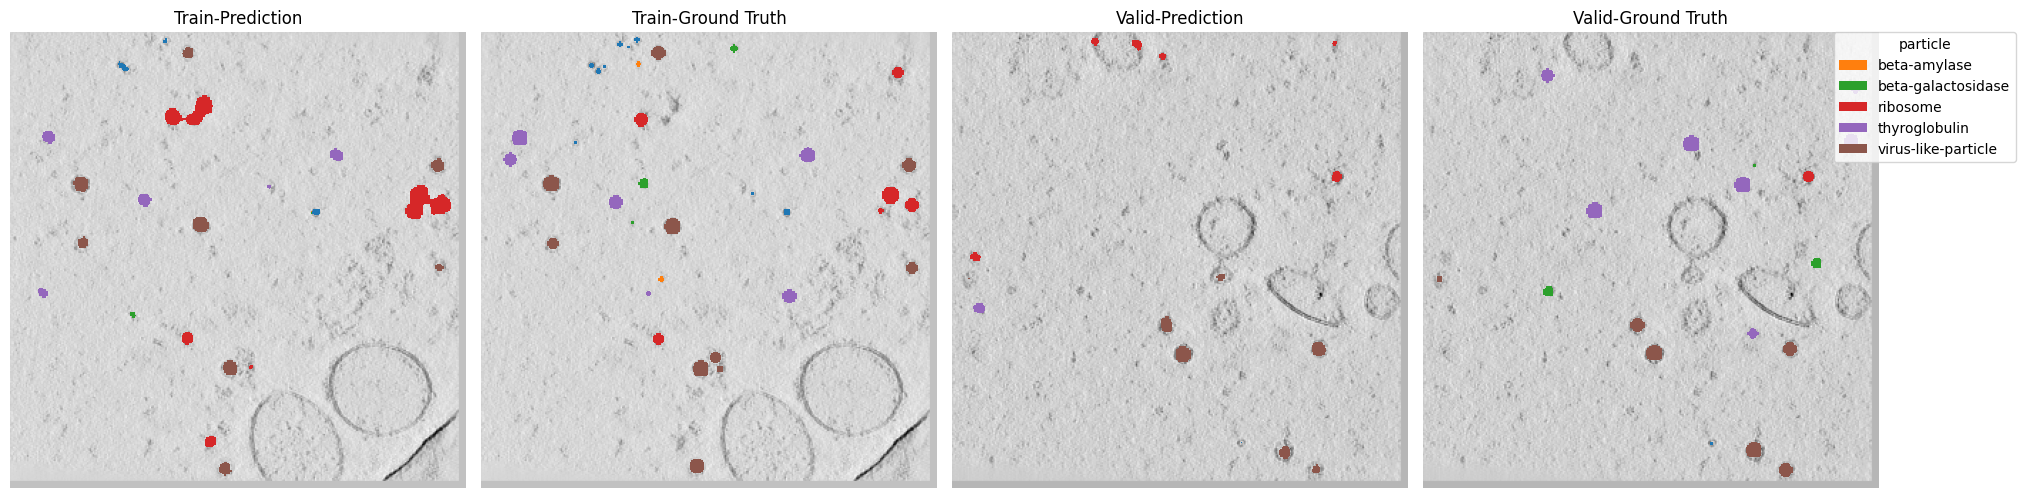

Train-Epoch: 2, Loss: 0.6765096291251804: : 46it [00:06,  7.54it/s]                      
Train-nshuffle-Epoch: 2, Loss: 0.6741502340721047: 100%|██████████| 460/460 [00:05<00:00, 82.65it/s] 


EPOCH: 2, TRAIN_SCORE: 0.22605916146480162, TRAIN_SCORE_LIST: [0.22625990400038318, 0.2103089674532981, 0.24046503835813823, 0.2173775587856223, 0.23588433872656633]


Valid-Epoch: 2, Loss: 0.7156816270688305: 100%|██████████| 184/184 [00:02<00:00, 74.41it/s] 


EPOCH: 2, VALID_SCORE: 0.21159026848264917, VALID_SCORE_LIST: [0.21575441265152265, 0.20742612431377566]


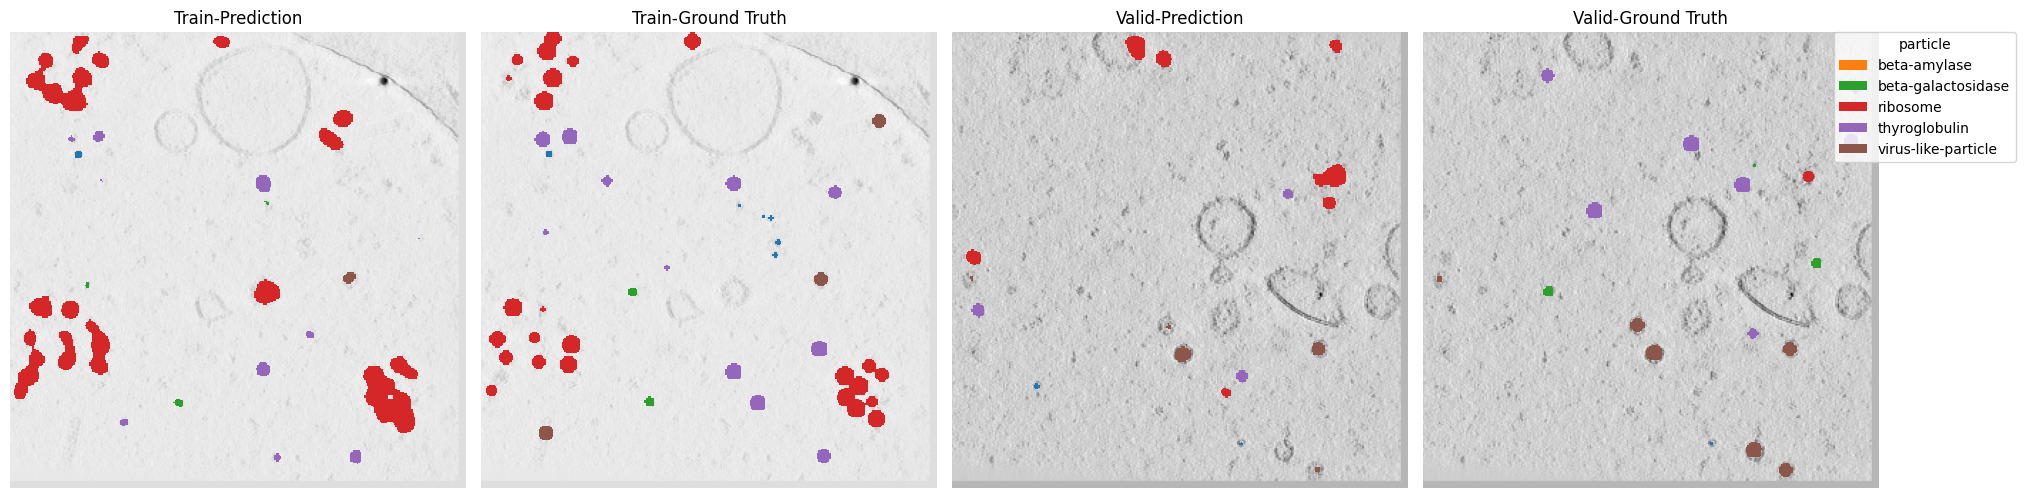

Train-Epoch: 3, Loss: 0.6277126320030378: : 46it [00:06,  7.49it/s]                      
Train-nshuffle-Epoch: 3, Loss: 0.6713239697010621: 100%|██████████| 460/460 [00:05<00:00, 83.70it/s] 


EPOCH: 3, TRAIN_SCORE: 0.4058581908926425, TRAIN_SCORE_LIST: [0.5044415514454864, 0.4182723726640642, 0.33265015898899486, 0.42580691459187736, 0.3481199567727895]


Valid-Epoch: 3, Loss: 0.7197628270672716: 100%|██████████| 184/184 [00:02<00:00, 71.74it/s] 


EPOCH: 3, VALID_SCORE: 0.36882774168765203, VALID_SCORE_LIST: [0.41026687806845125, 0.3273886053068528]


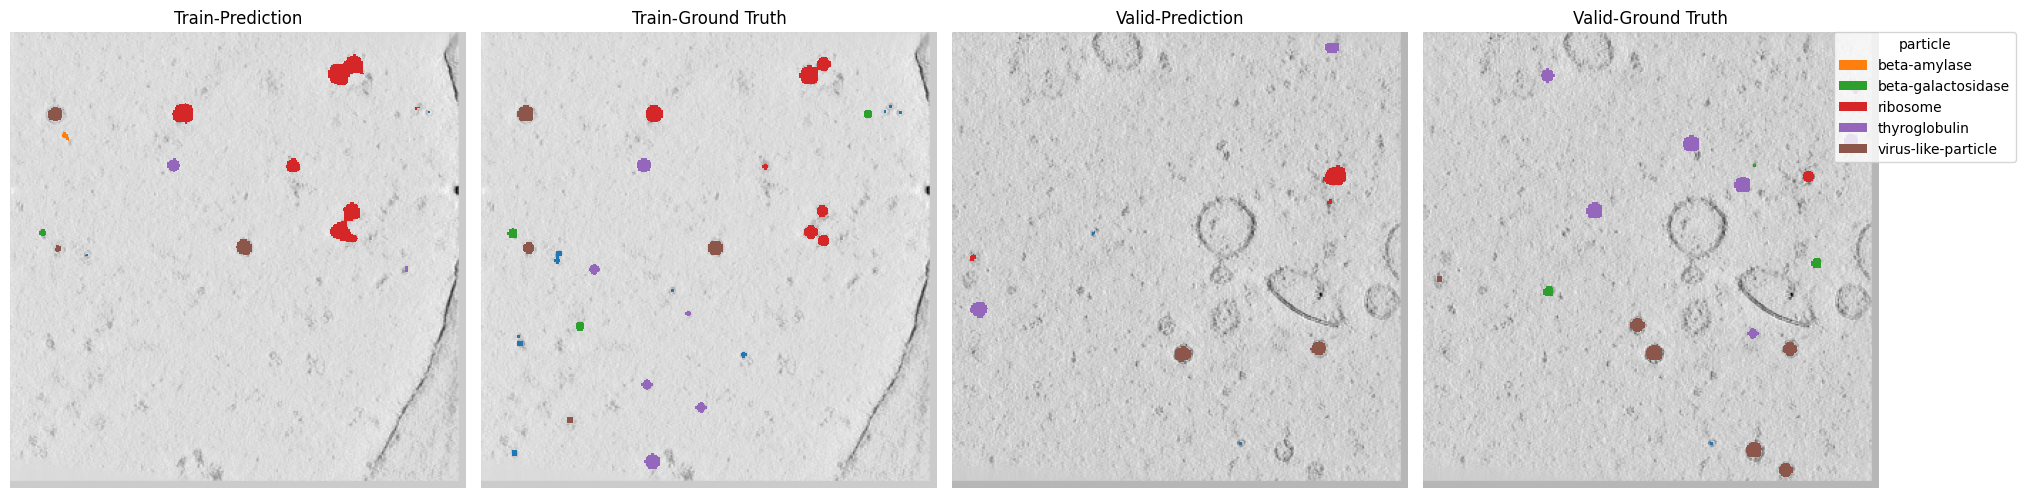

Train-Epoch: 4, Loss: 0.6457123873026475: : 46it [00:08,  5.52it/s]                      
Train-nshuffle-Epoch: 4, Loss: 0.6113741221635238: 100%|██████████| 460/460 [00:12<00:00, 35.91it/s]


EPOCH: 4, TRAIN_SCORE: 0.23834170635625762, TRAIN_SCORE_LIST: [0.22868982494463225, 0.264893127938486, 0.21594547864413424, 0.2189286435054914, 0.2632514567485441]


Valid-Epoch: 4, Loss: 0.6791318632338358: 100%|██████████| 184/184 [00:03<00:00, 51.22it/s]


EPOCH: 4, VALID_SCORE: 0.2369709863133821, VALID_SCORE_LIST: [0.2605353543917265, 0.21340661823503768]


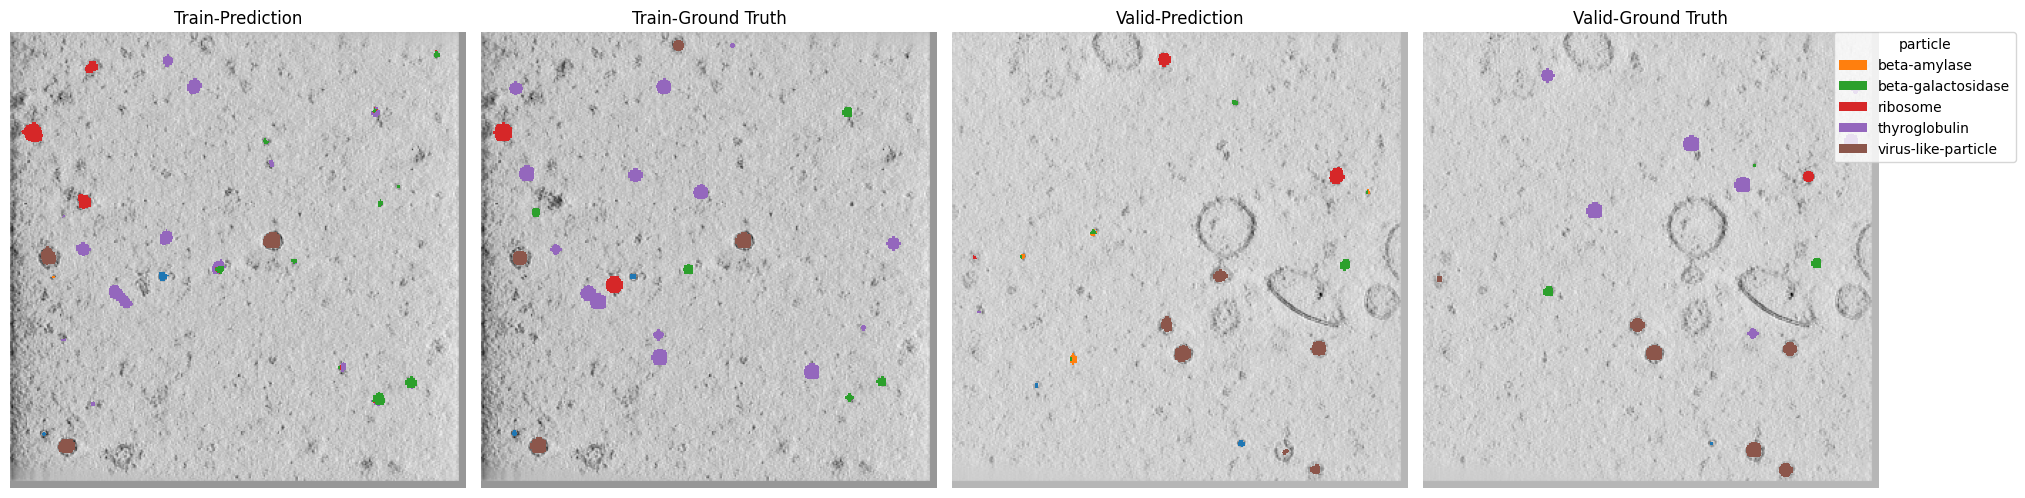

Train-Epoch: 5, Loss: 0.620810144621393: : 46it [00:08,  5.51it/s]                       
Train-nshuffle-Epoch: 5, Loss: 0.6055611259263495: 100%|██████████| 460/460 [00:06<00:00, 74.86it/s] 


EPOCH: 5, TRAIN_SCORE: 0.3307240622812132, TRAIN_SCORE_LIST: [0.32503026792723816, 0.31883356881362535, 0.36983334110536514, 0.3042253968230916, 0.3356977367367458]


Valid-Epoch: 5, Loss: 0.6932787438449652: 100%|██████████| 184/184 [00:02<00:00, 73.21it/s] 


EPOCH: 5, VALID_SCORE: 0.24413787193378647, VALID_SCORE_LIST: [0.27809434747986544, 0.2101813963877075]


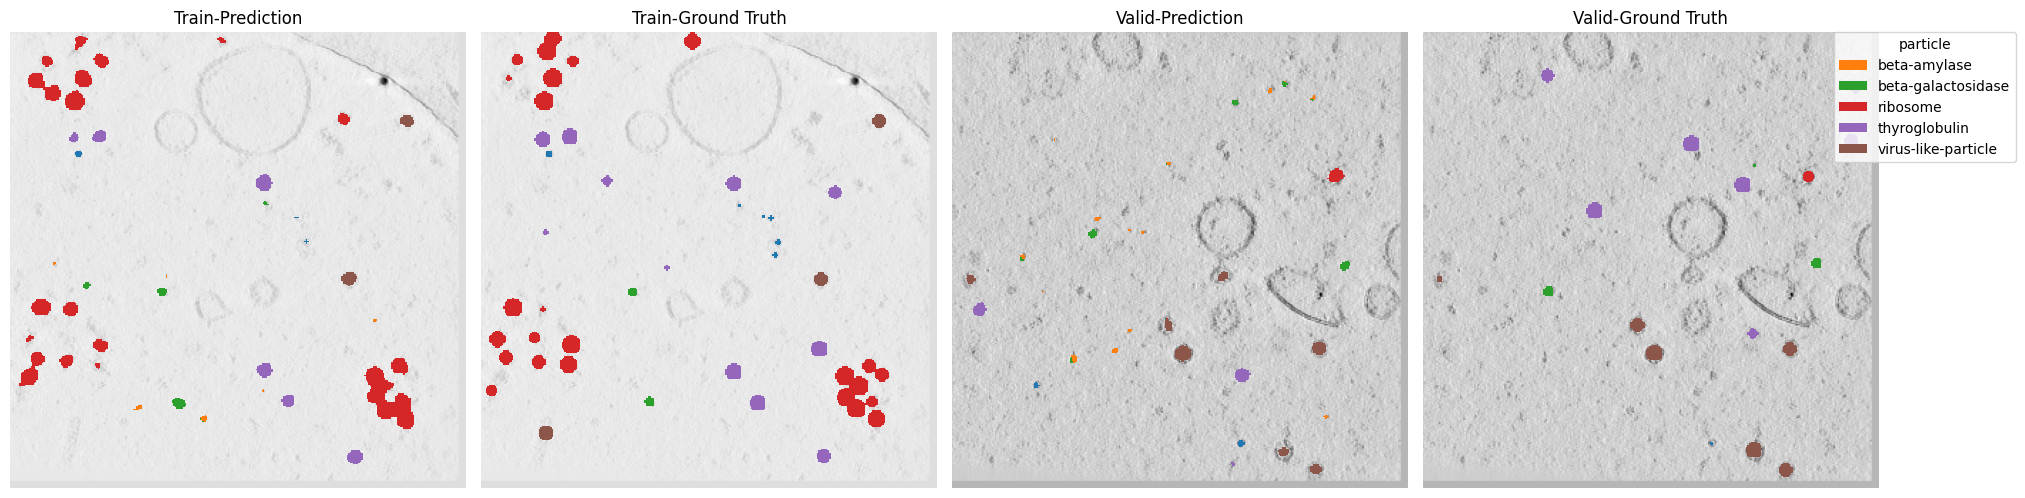

Train-Epoch: 6, Loss: 0.6075673194035239: : 46it [00:06,  6.62it/s]                      
Train-nshuffle-Epoch: 6, Loss: 0.5906929625117261: 100%|██████████| 460/460 [00:17<00:00, 26.78it/s]


EPOCH: 6, TRAIN_SCORE: 0.23624119928921794, TRAIN_SCORE_LIST: [0.24976090468961504, 0.2438177846826913, 0.26376604820267524, 0.2138901516637172, 0.20997110720739096]


Valid-Epoch: 6, Loss: 0.6757026923739392: 100%|██████████| 184/184 [00:03<00:00, 54.02it/s]


EPOCH: 6, VALID_SCORE: 0.20723949276270665, VALID_SCORE_LIST: [0.23991293803193448, 0.1745660474934788]


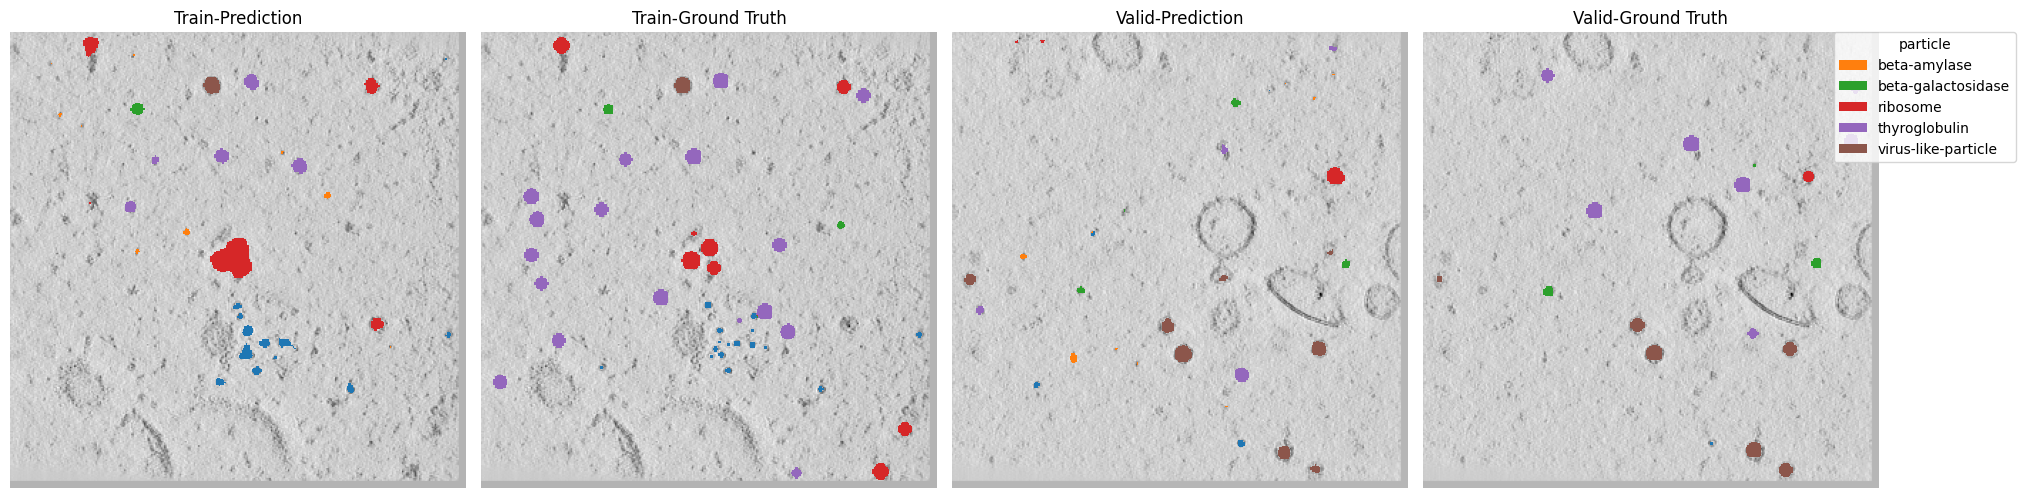

Train-Epoch: 7, Loss: 0.5810067614783412: : 46it [00:06,  7.46it/s]                      
Train-nshuffle-Epoch: 7, Loss: 0.5616523509440214: 100%|██████████| 460/460 [00:05<00:00, 80.10it/s]  


EPOCH: 7, TRAIN_SCORE: 0.3302005384770102, TRAIN_SCORE_LIST: [0.3082063673741016, 0.3062797063813786, 0.3926715729904831, 0.31294679411601983, 0.3308982515230678]


Valid-Epoch: 7, Loss: 0.6774157599910445: 100%|██████████| 184/184 [00:02<00:00, 71.07it/s] 


EPOCH: 7, VALID_SCORE: 0.24433011035182012, VALID_SCORE_LIST: [0.278726817346569, 0.20993340335707125]


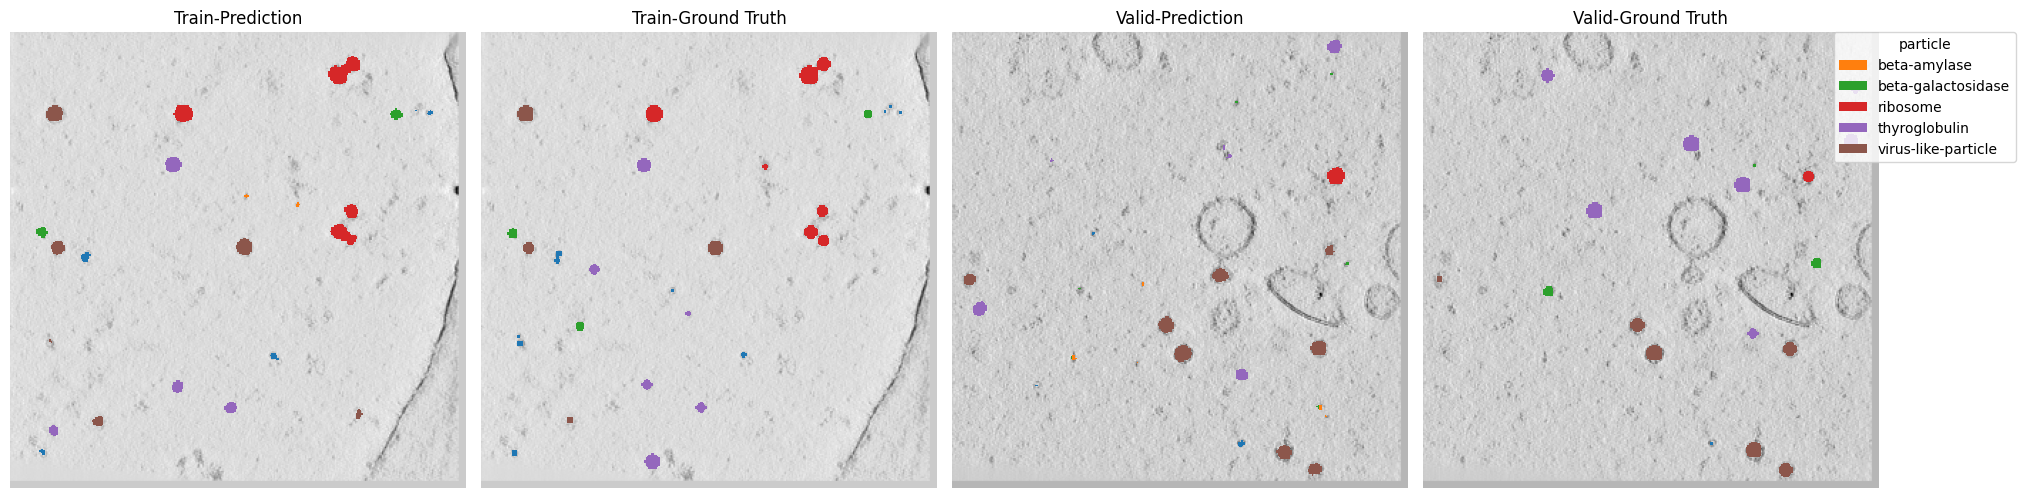

Train-Epoch: 8, Loss: 0.5593432058458743: : 46it [00:06,  7.46it/s]                      
Train-nshuffle-Epoch: 8, Loss: 0.5605738006208254: 100%|██████████| 460/460 [00:11<00:00, 40.46it/s]  


EPOCH: 8, TRAIN_SCORE: 0.5148927100083291, TRAIN_SCORE_LIST: [0.5122527038742397, 0.5245463383694221, 0.5762752789466503, 0.4760186523077571, 0.4853705765435767]


Valid-Epoch: 8, Loss: 0.6913301254744115: 100%|██████████| 184/184 [00:03<00:00, 52.86it/s]


EPOCH: 8, VALID_SCORE: 0.31922675768617154, VALID_SCORE_LIST: [0.3576701225381182, 0.2807833928342249]


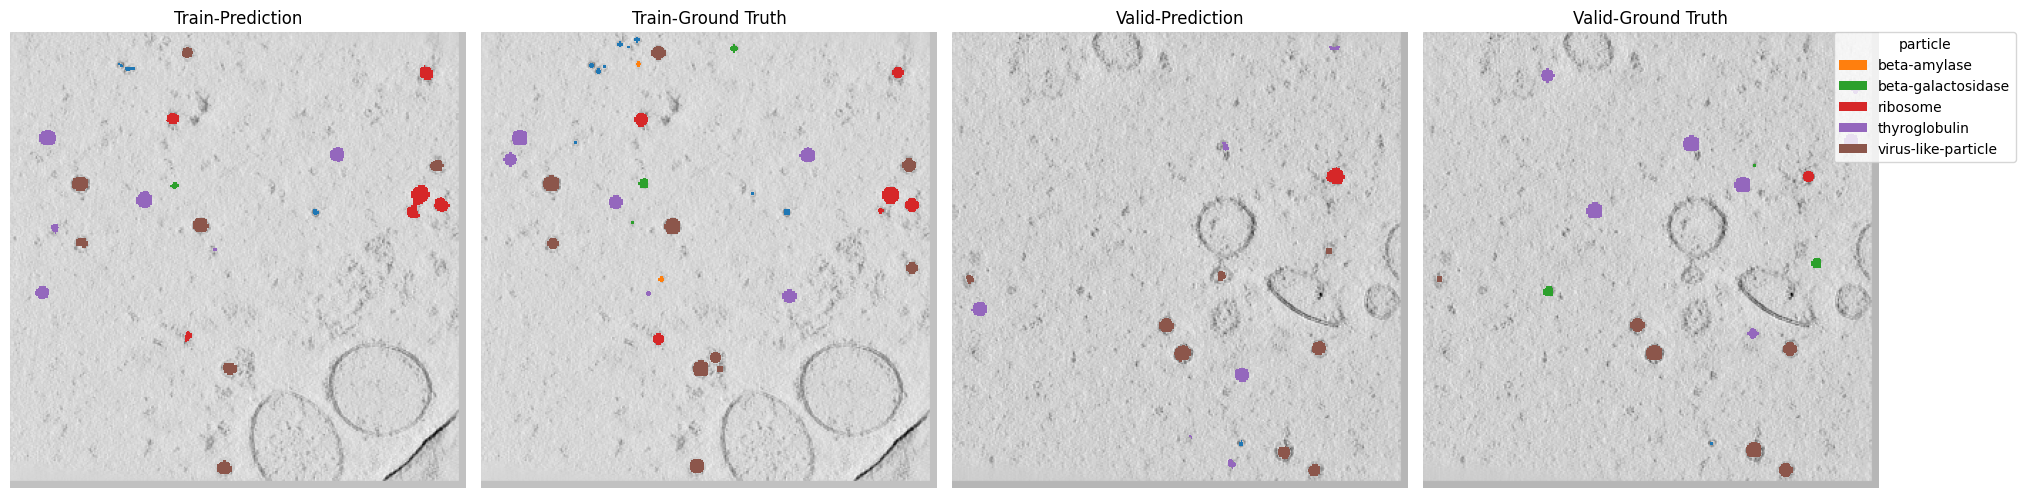

Train-Epoch: 9, Loss: 0.5370878356954326: : 46it [00:08,  5.16it/s]                       
Train-nshuffle-Epoch: 9, Loss: 0.5694700720517532: 100%|██████████| 460/460 [00:16<00:00, 28.09it/s] 


EPOCH: 9, TRAIN_SCORE: 0.5087588680763135, TRAIN_SCORE_LIST: [0.4976582888392353, 0.5142666050424893, 0.5782965093846225, 0.46515394693267637, 0.4884189901825443]


Valid-Epoch: 9, Loss: 0.70046380745328: 100%|██████████| 184/184 [00:02<00:00, 72.57it/s]   


EPOCH: 9, VALID_SCORE: 0.3577906548036063, VALID_SCORE_LIST: [0.39250071836935213, 0.3230805912378605]


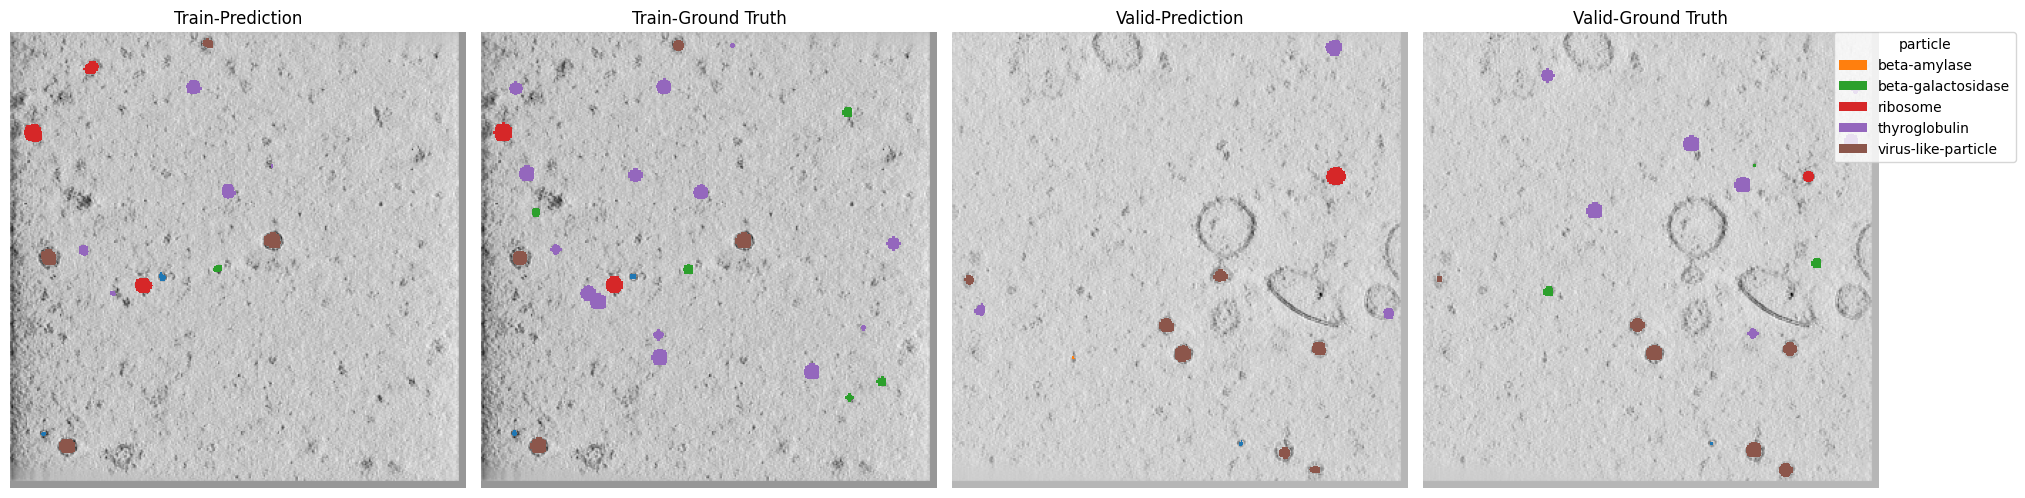

Train-Epoch: 10, Loss: 0.5363148722959601: : 46it [00:05,  7.69it/s]                      
Train-nshuffle-Epoch: 10, Loss: 0.5257162362337112: 100%|██████████| 460/460 [00:05<00:00, 81.34it/s]  


EPOCH: 10, TRAIN_SCORE: 0.4160845038240775, TRAIN_SCORE_LIST: [0.4785184657464712, 0.39968751892422955, 0.3921998830383249, 0.34604618910660595, 0.46397046230475597]


Valid-Epoch: 10, Loss: 0.6993644240757694: 100%|██████████| 184/184 [00:02<00:00, 70.86it/s] 


EPOCH: 10, VALID_SCORE: 0.28507992475530775, VALID_SCORE_LIST: [0.31075559243989404, 0.25940425707072146]


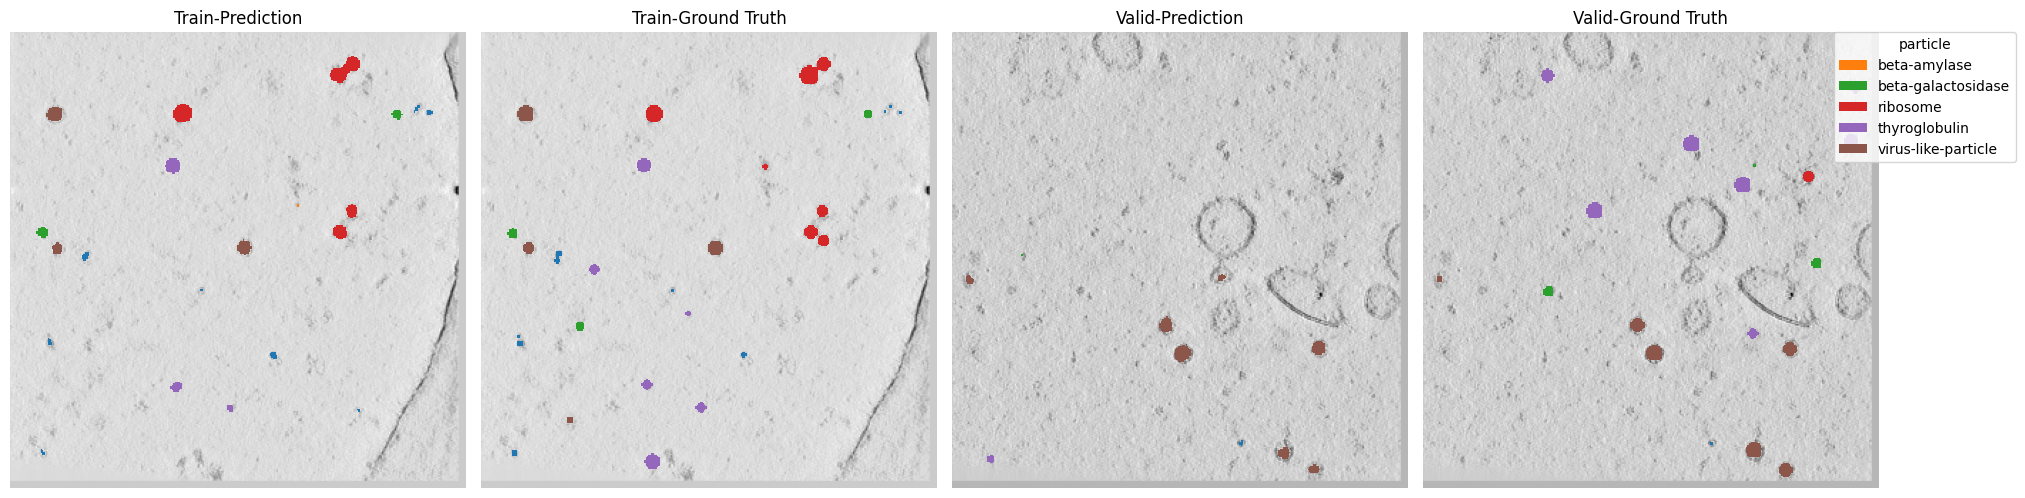

Train-Epoch: 11, Loss: 0.5129476954107699: : 46it [00:06,  7.62it/s]                       
Train-nshuffle-Epoch: 11, Loss: 0.5125964385011922: 100%|██████████| 460/460 [00:05<00:00, 81.06it/s]  


EPOCH: 11, TRAIN_SCORE: 0.6114509532226922, TRAIN_SCORE_LIST: [0.5941351059513521, 0.6218967100791042, 0.6800423187107523, 0.5342299254794017, 0.6269507058928507]


Valid-Epoch: 11, Loss: 0.6892338916659355: 100%|██████████| 184/184 [00:02<00:00, 73.87it/s] 


EPOCH: 11, VALID_SCORE: 0.31445530755290946, VALID_SCORE_LIST: [0.3365007881777826, 0.2924098269280363]


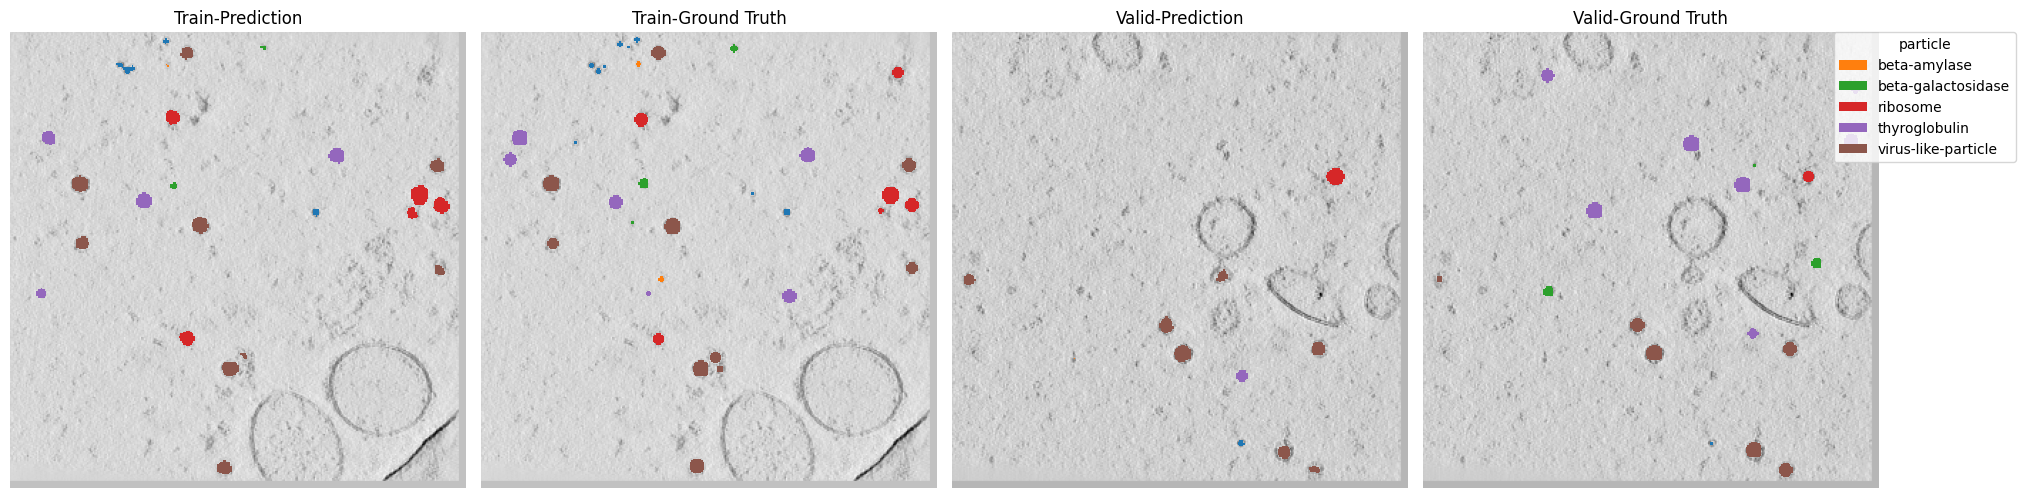

Train-Epoch: 12, Loss: 0.4985909980276357: : 46it [00:06,  7.50it/s]                      
Train-nshuffle-Epoch: 12, Loss: 0.5079372994277789: 100%|██████████| 460/460 [00:05<00:00, 78.12it/s]  


EPOCH: 12, TRAIN_SCORE: 0.5917125338694219, TRAIN_SCORE_LIST: [0.6210850687456817, 0.5442620518334556, 0.6664686657393253, 0.5063490418792627, 0.6203978411493839]


Valid-Epoch: 12, Loss: 0.7093633643311003: 100%|██████████| 184/184 [00:02<00:00, 76.21it/s] 


EPOCH: 12, VALID_SCORE: 0.3914065538440405, VALID_SCORE_LIST: [0.4295339817525072, 0.3532791259355738]


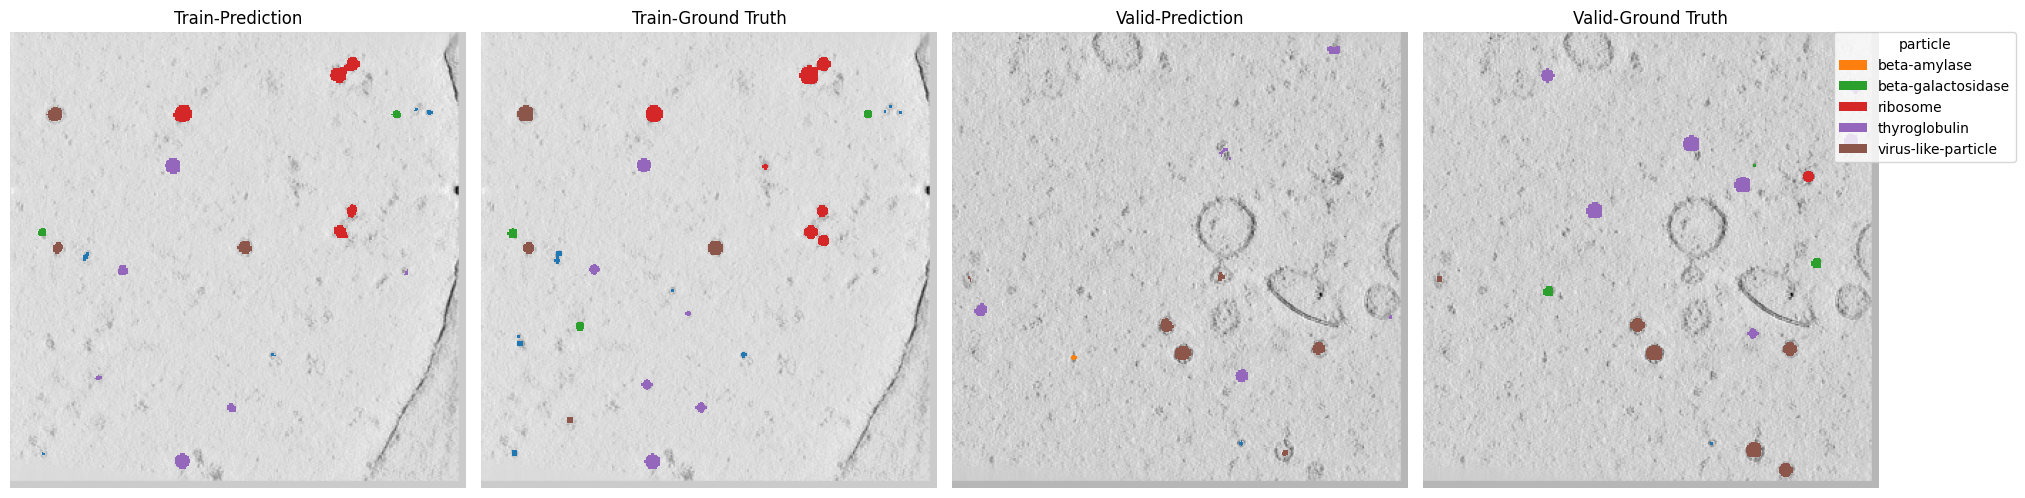

Train-Epoch: 13, Loss: 0.4739736214928005: : 46it [00:06,  7.53it/s]                       
Train-nshuffle-Epoch: 13, Loss: 0.500047532112702: 100%|██████████| 460/460 [00:05<00:00, 78.75it/s]   


EPOCH: 13, TRAIN_SCORE: 0.42561987169555493, TRAIN_SCORE_LIST: [0.40638596977809227, 0.4310305030881313, 0.49763622371465954, 0.37572120992937297, 0.41732545196751886]


Valid-Epoch: 13, Loss: 0.7013676117943681: 100%|██████████| 184/184 [00:04<00:00, 43.40it/s]


EPOCH: 13, VALID_SCORE: 0.29245236890266585, VALID_SCORE_LIST: [0.30721425610676184, 0.27769048169856986]


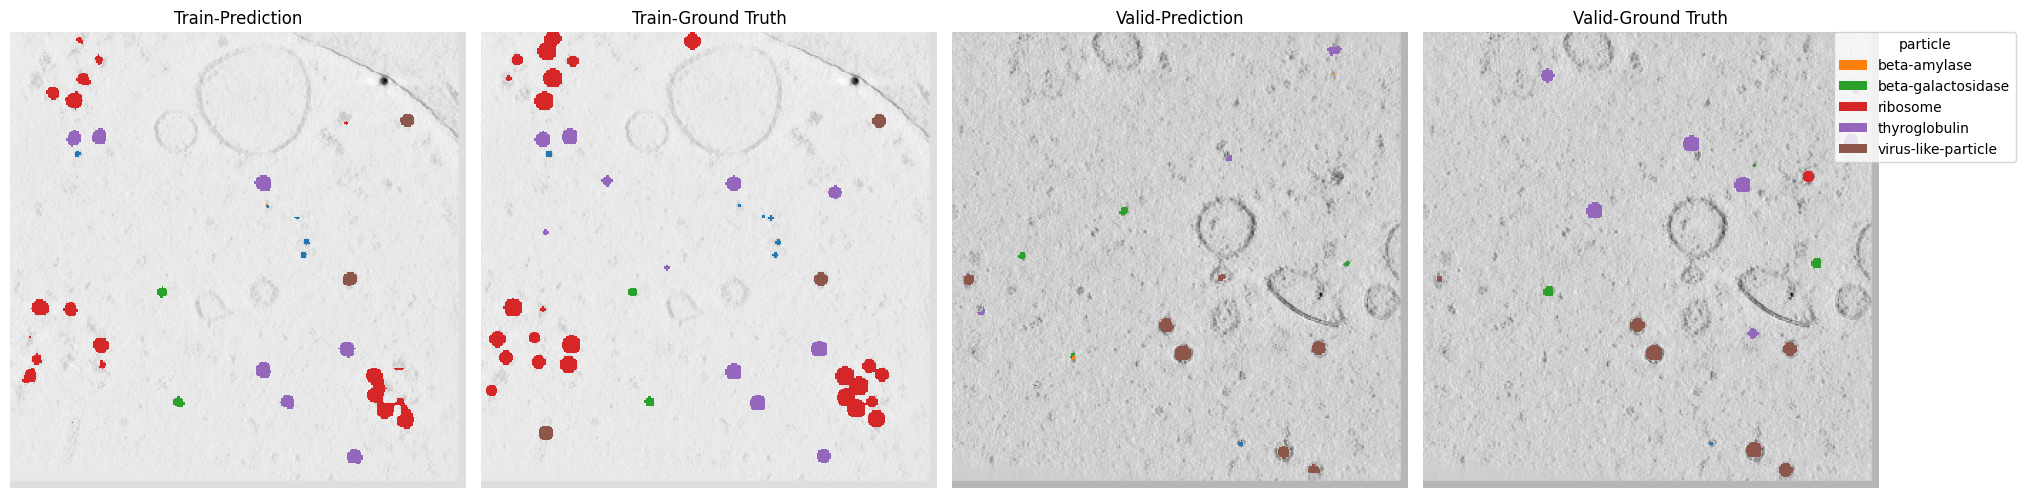

Train-Epoch: 14, Loss: 0.5569892048835754:  43%|████▎     | 10/23 [00:02<00:01,  8.08it/s]

In [ ]:
best_model = None
best_score = 0

for epoch in range(CFG.epochs):
    train_loss = []
    train_nshuffle_loss = []
    valid_loss = []

    # train_original_tomogram = defaultdict(list)
    ##train_pred_tomogram = defaultdict(list)
    # train_gt_tomogram = defaultdict(list)

    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    model.train()
    tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0] // batch_size))
    for data in train_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"]
        segmentation_map = data["segmentation_map"]

        tomogram = tomogram.reshape(1, -1, tomogram.shape[-2], tomogram.shape[-1])
        segmentation_map = segmentation_map.reshape(
            1, -1, segmentation_map.shape[-2], segmentation_map.shape[-1]
        )

        random_index = torch.randperm(tomogram.shape[1])

        for i in range(0, tomogram.shape[1], batch_size):
            optimizer.zero_grad()
            input_ = (
                tomogram[:, random_index[i : i + batch_size]].to("cuda").transpose(0, 1)
            )
            gt = (
                segmentation_map[:, random_index[i : i + batch_size]]
                .to("cuda")
                .long()
                .squeeze()
            )
            # print(input_.shape, gt.shape)

            input_ = padf(input_)
            gt = padf(gt)
            # input_, gt = aug(input_, gt)
            output = model(input_)
            loss = seg_loss(output, gt)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss.append(loss.item())
            tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            # train_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            # train_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()
    train_exp_name = exp_name

    ######################################## train-nshuffle #########################################
    model.eval()
    tq = tqdm(range(len(train_nshuffle_loader) * normalized_tomogram.shape[0]))
    for data in train_nshuffle_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        train_nshuffle_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            input_ = padf(input_)
            gt = padf(gt)
            output = model(input_)
            loss = seg_loss(output, gt)

            train_nshuffle_loss.append(loss.item())
            tq.set_description(
                f"Train-nshuffle-Epoch: {epoch}, Loss: {np.mean(train_nshuffle_loss)}"
            )
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            train_nshuffle_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            train_nshuffle_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()

    train_score_, train_score_list = visualize_epoch_results(
        train_nshuffle_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
    )
    print(
        f"EPOCH: {epoch}, TRAIN_SCORE: {train_score_}, TRAIN_SCORE_LIST: {train_score_list}"
    )

    ############################################# valid #############################################

    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        valid_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            input_ = padf(input_)
            gt = padf(gt)
            output = model(input_)
            loss = seg_loss(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            valid_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            valid_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()
    valid_exp_name = exp_name

    valid_score_, valid_score_list = visualize_epoch_results(
        valid_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
    )

    print(
        f"EPOCH: {epoch}, VALID_SCORE: {valid_score_}, VALID_SCORE_LIST: {valid_score_list}"
    )
    if valid_score_ > best_score:
        best_score = valid_score_
        best_model = model
        torch.save(model.state_dict(), f"best_model.pth")

    # 描画
    index = 30
    plt.figure(figsize=(20, 5))

    # Train-Pred-Plot
    ax = plt.subplot(1, 4, 1)
    pred = train_nshuffle_pred_tomogram[train_exp_name][index][0].argmax(0)
    plot_with_colormap(
        pred,
        "Train-Prediction",
        train_nshuffle_original_tomogram[train_exp_name][index],
    )

    # Train-GT-Plot
    ax = plt.subplot(1, 4, 2)
    gt = train_nshuffle_gt_tomogram[train_exp_name][index][0]
    plot_with_colormap(
        gt,
        "Train-Ground Truth",
        train_nshuffle_original_tomogram[train_exp_name][index],
    )

    # Valid-Pred-Plot
    ax = plt.subplot(1, 4, 3)
    pred = valid_pred_tomogram[valid_exp_name][index][0].argmax(0)
    plot_with_colormap(
        pred, "Valid-Prediction", valid_original_tomogram[valid_exp_name][index]
    )

    # Valid-GT-Plot
    ax = plt.subplot(1, 4, 4)
    gt = valid_gt_tomogram[valid_exp_name][index][0]
    plot_with_colormap(
        gt, "Valid-Ground Truth", valid_original_tomogram[valid_exp_name][index]
    )

    # 凡例を追加
    legend_elements = [
        Patch(facecolor=colors[i], label=CFG.particles_name[i])
        for i in range(1, num_classes)
    ]
    plt.legend(
        handles=legend_elements,
        loc="upper right",
        title="particle",
        bbox_to_anchor=(1.3, 1),  # 凡例を右上に配置
        borderaxespad=0,
    )

    plt.tight_layout()
    plt.show()

    # torch.save(model.state_dict(), "pretrained_model.pth")